Phase 3: Dataset Builder (YOLO-labeled Synthetic Image Dataset)

In [1]:
import os
import json
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from transformers import BlipProcessor, BlipForConditionalGeneration
import torch


C:\Users\AARUSHI TANDON\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# -------- Paths --------
IMAGE_DIR = r"C:\Users\AARUSHI TANDON\Downloads\all_images (1)"
LABELS_JSON = "detected_labels.json"
OUTPUT_JSONL = "final_dataset.jsonl"



In [3]:
# -------- Load YOLOv8-Labeled Results from Phase 2 --------
with open(LABELS_JSON, "r") as f:
    label_data = json.load(f)


In [4]:
# -------- Load BLIP Captioning Model --------
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


BlipForConditionalGeneration(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-0

In [5]:
# -------- Generate Captions with BLIP --------
def generate_caption(img_path):
    try:
        image = Image.open(img_path).convert('RGB')
        inputs = processor(image, return_tensors="pt").to(device)
        out = model.generate(**inputs)
        caption = processor.decode(out[0], skip_special_tokens=True)
        return caption
    except Exception as e:
        print(f"Caption failed for {img_path}: {e}")
        return "No caption"


In [6]:
# -------- Final Dataset Builder --------
entries = []

for idx, item in enumerate(label_data):
    full_img_path = os.path.join(IMAGE_DIR, item["image"])
    caption = generate_caption(full_img_path)

    #  Add this progress print
    print(f"[{idx+1}/{len(label_data)}] Processed: {item['image']}")
    print(f"     Objects: {item['objects']}")
    print(f"     Caption: {caption}")

    entry = {
        "image": item["image"],
        "caption": caption,
        "labels": {
            "objects": item["objects"],
            "relation": item["relationship"]
        }
    }
    entries.append(entry)


[1/250] Processed: ultra-realistic_photo_of_a_child_holding\20250704_170652_0.png
     Objects: ['person', 'frisbee']
     Caption: a little boy holding a ball in a playground
[2/250] Processed: ultra-realistic_photo_of_a_child_holding\20250704_170717_1.png
     Objects: ['person']
     Caption: a child holding a yellow ball
[3/250] Processed: ultra-realistic_photo_of_a_child_holding\20250704_170742_2.png
     Objects: ['person']
     Caption: a little girl playing with a toy
[4/250] Processed: ultra-realistic_photo_of_a_child_holding\20250704_170807_3.png
     Objects: ['person']
     Caption: a little girl playing with a toy in a water table
[5/250] Processed: ultra-realistic_photo_of_a_child_holding\20250704_170832_4.png
     Objects: ['person']
     Caption: a little boy playing on a playground
[6/250] Processed: ultra-realistic_photo_of_a_child_holding\20250704_181317_0.png
     Objects: ['person', 'baseball bat']
     Caption: a little girl holding a red toothbrush
[7/250] Proces

In [7]:

# -------- Save Final JSONL Dataset --------
with open(OUTPUT_JSONL, "w") as f:
    for entry in entries:
        f.write(json.dumps(entry) + "\n")

print(f"Final dataset with captions saved to {OUTPUT_JSONL}")

Final dataset with captions saved to final_dataset.jsonl


In [8]:
# -------- Sample Visualization --------
def show_sample(entry):
    img = Image.open(os.path.join(IMAGE_DIR, entry["image"]))
    plt.imshow(img)
    plt.title(f"Caption: {entry['caption']}\nObjects: {', '.join(entry['labels']['objects'])}")
    plt.axis('off')
    plt.show()



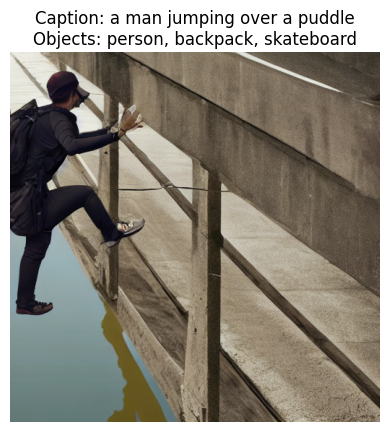

In [13]:
# -------- Display a Random Sample --------
import random
sample = random.choice(entries)
show_sample(sample)
